In [1]:
# -*- coding: utf-8 -*-
"""
Created on 2022

@author: S.W
"""

'\nCreated on 2022\n\n@author: S.W\n'

# 1. 학습에 필요한 라이브러리 import

In [2]:
import os
import PIL
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

# 2. CIFAR10 데이터셋 불러오기

In [3]:
# https://www.cs.toronto.edu/~kriz/cifar.html
# class : airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

from tensorflow.keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


In [4]:
from keras.utils import np_utils

# one-hot encoding
train_labels = np_utils.to_categorical(train_labels, 10)
test_labels = np_utils.to_categorical(test_labels, 10)

train_labels[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [5]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [6]:
X = np.concatenate([train_images, test_images])
y = np.concatenate([train_labels, test_labels])
print(np.concatenate([train_images, test_images]).shape)
print(np.concatenate([train_labels, test_labels]).shape)

(60000, 32, 32, 3)
(60000, 10)


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

train_set_X, test_set_X, train_set_y, test_set_y = train_test_split(X, y,
                                                    test_size=0.005,
                                                    train_size=0.02, random_state=42)

In [8]:
train_set_X.shape, test_set_X.shape, train_set_y.shape, test_set_y.shape

((1200, 32, 32, 3), (300, 32, 32, 3), (1200, 10), (300, 10))

In [9]:
np.sum(train_set_y, axis=0) , np.sum(test_set_y, axis=0)

(array([111., 128., 124., 126., 118., 129., 118., 133.,  92., 121.],
       dtype=float32),
 array([30., 35., 27., 30., 29., 38., 22., 28., 36., 25.], dtype=float32))

AxesImage(80,52.8;496x369.6)
숫자:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


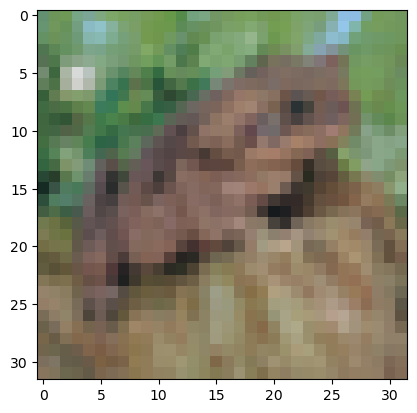

In [10]:
n = 200
print(plt.imshow(train_set_X[n]))
print("숫자: ",train_set_y[n])

# 3.Pre-Trained Model 불러오기

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

model = VGG16(input_shape=(32, 32, 3), include_top=False, weights=None)
# include_top : FC layer를 포함할지 안할지
# weight : None or "imagenet"
# input_shape : input tensor shape control

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [12]:
model.get_layer('block4_conv3')

In [13]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

output = model.get_layer('block2_pool').output # 모델의 가장 마지막 층 반환

# VGG16 모델 위에 신경망 쌓기
x = GlobalAveragePooling2D()(output)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=model.input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [14]:
# ImageDataGenerator를 통해 학습 데이터 Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

train_gen = ImageDataGenerator(
#     horizontal_flip=True,
    rescale=1/255.0
)

# 검증용 데이터 세트는 scale만 바꾸어주고 augmentation 적용하면 안됨
test_gen = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_gen.flow(train_set_X, train_set_y, batch_size=64, shuffle=True)
flow_test_gen = test_gen.flow(test_set_X, test_set_y, batch_size=64, shuffle=False)

In [15]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# 4. 모델 학습

In [16]:
## ealy stop
# 3번 반복내에 validation loss가 줄어들지 않으면 learning rate를 0.2 감소
lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
# 5번 반복내에 validation loss가 줄어들지 않으면 강제종료
st_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

# result = model.fit(flow_tr_gen, epochs=50, validation_data=flow_test_gen, callbacks=[lr_cb, st_cb])
history = model.fit(flow_tr_gen, epochs=50, validation_data=flow_test_gen)

Epoch 1/50


2023-04-21 17:27:36.791152: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


19/19 [==============================] - 23s 1s/step - loss: 2.3036 - accuracy: 0.0892 - val_loss: 2.3032 - val_accuracy: 0.1000
Epoch 2/50
19/19 [==============================] - 20s 1s/step - loss: 2.3010 - accuracy: 0.1075 - val_loss: 2.3053 - val_accuracy: 0.0933
Epoch 3/50
19/19 [==============================] - 20s 1s/step - loss: 2.2997 - accuracy: 0.0967 - val_loss: 2.3059 - val_accuracy: 0.0933
Epoch 4/50
19/19 [==============================] - 20s 1s/step - loss: 2.2995 - accuracy: 0.1108 - val_loss: 2.3069 - val_accuracy: 0.0933
Epoch 5/50
19/19 [==============================] - 20s 1s/step - loss: 2.2993 - accuracy: 0.1108 - val_loss: 2.3081 - val_accuracy: 0.0933
Epoch 6/50
19/19 [==============================] - 19s 991ms/step - loss: 2.3005 - accuracy: 0.1100 - val_loss: 2.3069 - val_accuracy: 0.0933
Epoch 7/50
19/19 [==============================] - 18s 977ms/step - loss: 2.2861 - accuracy: 0.1300 - val_loss: 2.2981 - val_accuracy: 0.1033
Epoch 8/50
19/19 [=======

5/5 [==============================] - 1s 176ms/step - loss: 2.9273 - accuracy: 0.4100

Accuracy: 0.4100


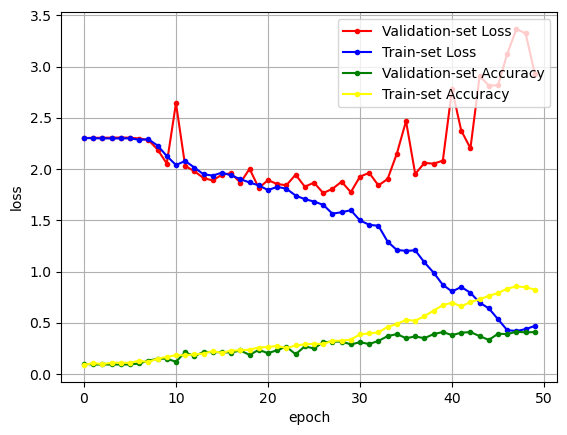

In [17]:
# 출처
# https://snowdeer.github.io/machine-learning/2018/01/10/check-relation-between-epoch-and-loss-using-graph/

print('\nAccuracy: {:.4f}'.format(model.evaluate(flow_test_gen)[1]))

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

y_vacc = history.history['val_accuracy']
y_acc = history.history['accuracy']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vacc, marker='.', c='green', label="Validation-set Accuracy")
plt.plot(x_len, y_acc, marker='.', c='yellow', label="Train-set Accuracy")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# plt.legend(loc='upper left')
# plt.grid()
# plt.xlabel('epoch')
# plt.ylabel('Accuracy')
# plt.show()

In [18]:
# 모델 테스트 데이터 예측값 출력
y_pred = model.predict(flow_test_gen)
y_pred

array([[8.43085170e-01, 4.12723282e-03, 5.40542416e-04, ...,
        6.70571462e-04, 1.50370806e-01, 1.12621719e-03],
       [5.42401940e-05, 4.74259082e-07, 1.21973315e-02, ...,
        4.61657837e-05, 5.76629361e-07, 8.69127325e-05],
       [2.83879065e-03, 1.40831125e-05, 5.33719957e-01, ...,
        2.87266448e-03, 8.23523533e-06, 8.12391881e-05],
       ...,
       [1.00703565e-02, 3.75915231e-04, 1.62191704e-01, ...,
        1.85512647e-03, 8.60896369e-04, 2.21331487e-03],
       [1.71328019e-02, 4.82452393e-01, 3.38166137e-05, ...,
        2.33600604e-05, 3.49070653e-02, 4.65447932e-01],
       [3.74701049e-05, 2.96628215e-08, 1.61344841e-01, ...,
        1.43927056e-04, 1.15069936e-08, 1.19957849e-06]], dtype=float32)

In [19]:
# 열 단위, 가장 높은 값을 반환

np.argmax(test_set_y, axis=1) # ground truth
np.argmax(y_pred, axis=1)     # predict

array([0, 5, 2, 8, 7, 6, 1, 5, 8, 0, 5, 3, 3, 8, 1, 7, 7, 4, 9, 5, 3, 1,
       8, 3, 0, 1, 5, 2, 9, 0, 1, 2, 9, 9, 9, 0, 7, 5, 2, 5, 4, 1, 6, 4,
       3, 2, 9, 9, 9, 0, 6, 1, 8, 8, 0, 3, 6, 2, 1, 3, 1, 7, 3, 3, 1, 0,
       3, 1, 8, 8, 1, 9, 2, 0, 5, 9, 8, 8, 8, 9, 2, 2, 7, 5, 2, 3, 8, 8,
       9, 7, 4, 8, 3, 6, 3, 5, 0, 1, 9, 3, 0, 7, 8, 1, 8, 1, 9, 1, 5, 2,
       4, 7, 5, 7, 7, 2, 2, 1, 3, 5, 1, 0, 2, 8, 0, 5, 3, 3, 6, 9, 5, 3,
       5, 2, 3, 7, 9, 3, 7, 1, 9, 5, 3, 2, 7, 3, 9, 1, 5, 0, 2, 3, 7, 8,
       0, 2, 0, 8, 2, 4, 1, 0, 9, 8, 5, 4, 0, 1, 7, 2, 3, 3, 8, 5, 4, 5,
       7, 7, 2, 0, 5, 7, 5, 9, 1, 7, 5, 6, 2, 1, 9, 4, 0, 7, 5, 9, 5, 5,
       5, 0, 2, 5, 1, 8, 3, 2, 2, 3, 3, 3, 3, 9, 3, 2, 5, 0, 1, 9, 1, 9,
       7, 1, 8, 9, 2, 5, 8, 3, 4, 5, 8, 2, 7, 1, 8, 3, 3, 0, 7, 0, 1, 9,
       6, 9, 1, 3, 7, 3, 5, 3, 7, 4, 6, 1, 2, 7, 7, 2, 6, 5, 5, 9, 2, 4,
       2, 3, 3, 7, 9, 8, 5, 4, 3, 9, 9, 8, 4, 9, 7, 9, 5, 6, 4, 7, 0, 4,
       6, 5, 8, 8, 7, 6, 0, 3, 5, 9, 9, 3, 1, 5])

# 5. 모델 평가

In [20]:
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(test_set_y, axis=1), np.argmax(y_pred, axis=1))

0.41

# 6. Data Augmentation을 통한 성능 개선

In [21]:
train_gen = ImageDataGenerator(
    horizontal_flip = True,
#     rotation_range = 45,
#     width_shift_range = 0.2,
#     zoom_range = 0.2,
#     fill_mode='nearest',
    rescale=1/255.0
)

# 검증용 데이터 세트는 scale만 바꾸어주고 augmentation 적용하면 안됨
test_gen = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_gen.flow(train_set_X, train_set_y, batch_size=64, shuffle=True)
flow_test_gen = test_gen.flow(test_set_X, test_set_y, batch_size=64, shuffle=False)

In [22]:
model = VGG16(input_shape=(32, 32, 3), include_top=False, weights=None)
output = model.get_layer('block4_conv3').output # 모델의 가장 마지막 층 반환

# VGG16 모델 위에 신경망 쌓기
x = GlobalAveragePooling2D()(output)
x = Dense(64, activation='relu')(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=model.input, outputs=output)

In [23]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# 3번 반복내에 validation loss가 줄어들지 않으면 learning rate를 0.2 감소
lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
# 5번 반복내에 validation loss가 줄어들지 않으면 강제종료
st_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

# result = model.fit(flow_tr_gen, epochs=100, validation_data=flow_test_gen, callbacks=[lr_cb, st_cb])
history = model.fit(flow_tr_gen, epochs=100, validation_data=flow_test_gen)

Epoch 1/100
19/19 [==============================] - 18s 929ms/step - loss: 2.3053 - accuracy: 0.0925 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 2/100
19/19 [==============================] - 17s 911ms/step - loss: 2.2940 - accuracy: 0.0917 - val_loss: 2.2901 - val_accuracy: 0.0900
Epoch 3/100
19/19 [==============================] - 17s 885ms/step - loss: 2.2143 - accuracy: 0.1475 - val_loss: 2.1942 - val_accuracy: 0.1533
Epoch 4/100
19/19 [==============================] - 17s 905ms/step - loss: 2.2145 - accuracy: 0.1517 - val_loss: 2.2363 - val_accuracy: 0.1433
Epoch 5/100
19/19 [==============================] - 17s 917ms/step - loss: 2.1402 - accuracy: 0.1633 - val_loss: 2.0656 - val_accuracy: 0.2067
Epoch 6/100
19/19 [==============================] - 17s 907ms/step - loss: 2.0008 - accuracy: 0.2042 - val_loss: 1.9993 - val_accuracy: 0.1967
Epoch 7/100
19/19 [==============================] - 18s 937ms/step - loss: 1.9422 - accuracy: 0.2167 - val_loss: 1.9899 - val_accuracy:

19/19 [==============================] - 17s 901ms/step - loss: 0.4300 - accuracy: 0.8533 - val_loss: 2.4371 - val_accuracy: 0.4433
Epoch 58/100
19/19 [==============================] - 16s 871ms/step - loss: 0.3977 - accuracy: 0.8467 - val_loss: 3.2090 - val_accuracy: 0.3500
Epoch 59/100
19/19 [==============================] - 17s 876ms/step - loss: 0.3255 - accuracy: 0.8842 - val_loss: 3.1465 - val_accuracy: 0.3933
Epoch 60/100
19/19 [==============================] - 8s 427ms/step - loss: 0.3451 - accuracy: 0.8733 - val_loss: 2.9455 - val_accuracy: 0.4233
Epoch 61/100
19/19 [==============================] - 8s 402ms/step - loss: 0.3247 - accuracy: 0.8825 - val_loss: 2.9350 - val_accuracy: 0.4200
Epoch 62/100
19/19 [==============================] - 8s 406ms/step - loss: 0.3240 - accuracy: 0.9025 - val_loss: 3.3733 - val_accuracy: 0.4200
Epoch 63/100
19/19 [==============================] - 8s 400ms/step - loss: 0.2834 - accuracy: 0.8892 - val_loss: 3.1109 - val_accuracy: 0.3933
Ep

In [ ]:
# 출처
# https://snowdeer.github.io/machine-learning/2018/01/10/check-relation-between-epoch-and-loss-using-graph/

print('\nAccuracy: {:.4f}'.format(model.evaluate(flow_test_gen)[1]))

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
# 모델 테스트 데이터 예측값 출력
y_pred = model.predict(flow_test_gen)
y_pred

In [ ]:
# 열 단위, 가장 높은 값을 반환

# np.argmax(test_set_y, axis=1) # ground truth
# np.argmax(y_pred, axis=1)     # predict

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(test_set_y, axis=1), np.argmax(y_pred, axis=1))